<a href="https://colab.research.google.com/github/2813/dls-homework/blob/main/simpsone_home.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

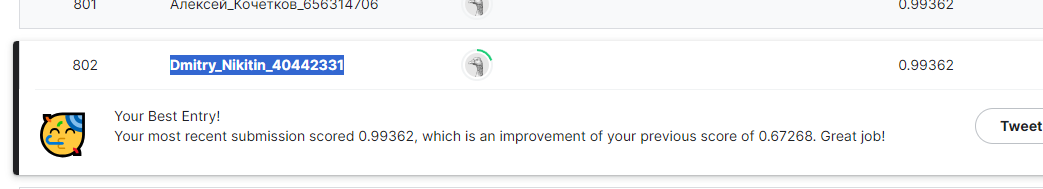

In [ ]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
import PIL
print(PIL.__version__)

9.5.0


In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Nov 19 23:54:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    32W / 250W |   6593MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [ ]:
import pickle
import numpy as np
import pandas as pd
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [ ]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
#DEVICE = torch.device("cuda")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
#определим директории с тренировочными и тестовыми файлами
TRAIN_DIR = Path( '/kaggle/input/journey-springfield/train/simpsons_dataset/')
TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')

#len(list(TEST_DIR.rglob('*.jpg'))), len(list(TRAIN_DIR.rglob('*.jpg'))), len(list(Path('/kaggle/input/journey-springfield/').rglob("*.csv")))

In [ ]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
#посмотрим какие персонажи присутствуют и в каком количестве
pd.Series(train_val_labels).value_counts()

homer_simpson               2246
ned_flanders                1454
moe_szyslak                 1452
lisa_simpson                1354
bart_simpson                1342
marge_simpson               1291
krusty_the_clown            1206
principal_skinner           1194
charles_montgomery_burns    1193
milhouse_van_houten         1079
chief_wiggum                 986
abraham_grampa_simpson       913
sideshow_bob                 877
apu_nahasapeemapetilon       623
kent_brockman                498
comic_book_guy               469
edna_krabappel               457
nelson_muntz                 358
lenny_leonard                310
mayor_quimby                 246
waylon_smithers              181
maggie_simpson               128
groundskeeper_willie         121
barney_gumble                106
selma_bouvier                103
carl_carlson                  98
ralph_wiggum                  89
patty_bouvier                 72
martin_prince                 71
professor_john_frink          65
snake_jail

In [ ]:
# видим, что некоторые персонажи представлены очень мальким числом экземляров. например lionel_hutz всего три примера.
# Какая бы навороченная модель не была, на трех примерах обучиться невозможно.

#Самый простой способ это накачать из интернета еще картинок для lionel_hutz и создать свой собственный дополнительный
# dataset.

#Однако при попытке создать свой собтвенный датасет,
#каггл предупреждает, что датасет с подобными картинками уже существует.
# Будем использовать его. Добавим jouney_springfiled-extended к себе в ноутбук

In [ ]:
EXTENDED_TRAIN = Path('/kaggle/input/journey-springfield-extended/')
train_val_files += sorted(list(EXTENDED_TRAIN.rglob('*.jpg')))

In [ ]:
train_val_labels = [path.parent.name for path in train_val_files]
#теперь "редкие" персонажи стали немного чаще встречаться в выборке
pd.Series(train_val_labels).value_counts()

homer_simpson               2246
ned_flanders                1454
moe_szyslak                 1452
lisa_simpson                1354
bart_simpson                1342
marge_simpson               1291
krusty_the_clown            1206
principal_skinner           1194
charles_montgomery_burns    1193
milhouse_van_houten         1079
chief_wiggum                 986
abraham_grampa_simpson       913
sideshow_bob                 877
apu_nahasapeemapetilon       623
kent_brockman                498
comic_book_guy               469
edna_krabappel               457
nelson_muntz                 358
lenny_leonard                310
mayor_quimby                 246
waylon_smithers              181
maggie_simpson               128
groundskeeper_willie         121
barney_gumble                106
selma_bouvier                103
carl_carlson                  98
ralph_wiggum                  89
patty_bouvier                 72
martin_prince                 71
professor_john_frink          65
snake_jail

In [ ]:
from collections import Counter
from torchvision.datasets import ImageFolder
from torch.utils.data import WeightedRandomSampler, ConcatDataset

#TRAIN_DIR = Path('/kaggle/input/journey-springfield/train/simpsons_dataset/')
#TEST_DIR = Path('/kaggle/input/journey-springfield/testset/testset')
#EXTENDED_TRAIN = Path('/kaggle/input/journey-springfield-extended/')

transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
augmented_transform = transforms.Compose([  # здесь можно еще попробовать не все сразу, а выборочно через RandomChoice
    transforms.RandomResizedCrop(220),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_v1 = ImageFolder(root=str(TRAIN_DIR), transform=transform)
train_ext = ImageFolder(root=str(EXTENDED_TRAIN), transform=transform)
train_aug = ImageFolder(root=str(TRAIN_DIR), transform=augmented_transform)
train = ConcatDataset([train_v1, train_ext, train_aug])
# получили порядка 40к изображений (20к исходные, плюс 20к аугментированые)


# чтобы редкие классы распределинить равномерно среди всех батчей и учить модель и на редких персонажах
# используем WeightedRandomSampler. Подробнее в разделе Discussion
# или https://www.kaggle.com/code/vladislavzenin/weightedrandomsampler
class_labels = [label for _, label in train_v1.samples]
class_counts = Counter(class_labels)
weights = [len(train) / (class_counts[i] * len(class_counts)) for i in class_labels]
sampler = WeightedRandomSampler(weights, num_samples=len(train), replacement=True)

test = ImageFolder(root='/kaggle/input/journey-springfield/testset', transform=transform)

In [ ]:
train_loader = DataLoader(train, batch_size=128, sampler=sampler, num_workers=2)
test_loader = DataLoader(test, shuffle=False)

In [ ]:
# Будем использовать претренированную модель resnet34


from torchvision.models import resnet34
model = resnet34(pretrained=True)
model  # видим, что последний слой 512 входных, 1000 выходных фич. Заменим его на слой 512-42 (у нас 42 персонажа)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.fc = nn.Linear(512, 42)  #заменяем последний линейный слой
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
def fit(epochs, model, loss_func, opt, dataloader, scheduler):
    train_losses = []

    for epoch in tqdm(range(epochs)):
        model.train()
        loss_sum = 0
        for x, y in tqdm(dataloader, desc=f'epoch={epoch+1}'):
            x, y, = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            loss = loss_func(model(x), y)
            loss_sum += loss.item()
            loss.backward()
            opt.step()

        train_losses.append(loss_sum / len(dataloader))
        scheduler.step()

        print(f'Epoch {epoch+1}: Train Loss = {round(train_losses[-1], 7)},  lr = {scheduler.get_last_lr()[0]}')

    return train_losses

loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(opt, milestones=[5, 9], gamma=0.5) #уменьшаем lr начиная с пятой эпохи

In [ ]:
epochs = 10 # поэкспериментировать с  эпохами
info = fit(epochs, model, loss_func, opt, train_loader, scheduler)

 10%|█         | 1/10 [01:55<17:22, 115.87s/it]

Epoch 1: Train Loss = 0.2737,  lr = 0.001



 20%|██        | 2/10 [03:55<15:44, 118.08s/it]

Epoch 2: Train Loss = 0.0866979,  lr = 0.001



 30%|███       | 3/10 [05:54<13:49, 118.54s/it]

Epoch 3: Train Loss = 0.0545418,  lr = 0.001



 40%|████      | 4/10 [07:53<11:51, 118.58s/it]

Epoch 4: Train Loss = 0.0457823,  lr = 0.001



 50%|█████     | 5/10 [09:52<09:54, 118.87s/it]

Epoch 5: Train Loss = 0.0327359,  lr = 0.0005



 60%|██████    | 6/10 [11:51<07:55, 118.92s/it]

Epoch 6: Train Loss = 0.0115268,  lr = 0.0005



 70%|███████   | 7/10 [13:50<05:56, 118.96s/it]

Epoch 7: Train Loss = 0.0048875,  lr = 0.0005



 80%|████████  | 8/10 [15:49<03:58, 119.07s/it]

Epoch 8: Train Loss = 0.0048787,  lr = 0.0005



 90%|█████████ | 9/10 [17:48<01:58, 118.77s/it]

Epoch 9: Train Loss = 0.0071339,  lr = 0.00025



100%|██████████| 10/10 [19:47<00:00, 118.71s/it]

Epoch 10: Train Loss = 0.0031671,  lr = 0.00025


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_conte

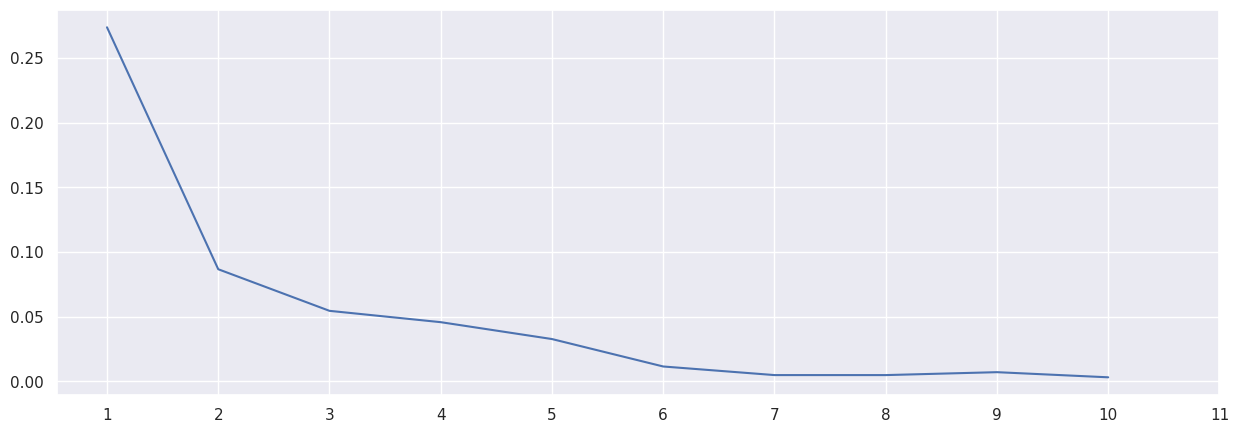

In [ ]:
import seaborn as sns
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(15, 5))
sns.lineplot(x=range(1, 11), y=info)
plt.xticks(range(1, 12))
plt.show()

In [ ]:
classes = train_v1.classes

model.eval()
y_pred = []
with torch.no_grad():
    for x, y in tqdm(test_loader):
        x = x.to(DEVICE)
        output = model(x)
        logit = torch.nn.functional.softmax(output, dim=1)
        _, pred_index = torch.max(logit, dim=1)
        y_pred.append(pred_index.item())

100%|██████████| 991/991 [00:09<00:00, 105.96it/s]


In [ ]:
from pathlib import Path

test_files = sorted(list(Path('/kaggle/input/journey-springfield/testset/testset').rglob('*.jpg')))

my_submit = pd.read_csv("/kaggle/input/journey-springfield/sample_submission.csv")
test_filenames = [path.name for path in test_files]
expected = [classes[index] for index in y_pred]
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': expected})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
my_submit.to_csv('submission.csv', index=False)